# Stereo Estimation

### Visualizing 3D data

Throughout the course, you will create mesh files (the ones with `ply` extension) for storing 3D data. You can visualize 3D data using a program such as MeshLab or Open3D. We recommend you to visualize `ply` files in your local machine as it is challenging in a notebook.   

**MeshLab**:
*   Install MeshLab: https://www.meshlab.net/#download
*   Visualize ply files: dragging `ply` file into an open MeshLab window should work.

**Open3D**:   
*   Install Open3D: http://www.open3d.org/docs/release/getting_started.html
*   Visualize ply file: http://www.open3d.org/docs/latest/tutorial/Basic/file_io.html#Mesh



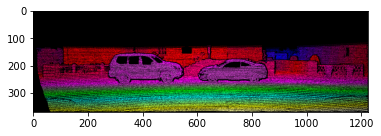

In [1]:
import matplotlib.pyplot as plt
from util import *

# load the data
leftI = load_image('data/000005_10_left_color.png')
rightI = load_image('data/000005_10_right_color.png')
dispI_gt = load_disp('data/000005_10_gt.png')
max_disp = np.max(dispI_gt)

plt.imshow(disp_to_color(dispI_gt, max_disp))

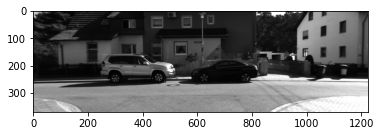

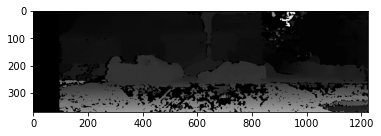

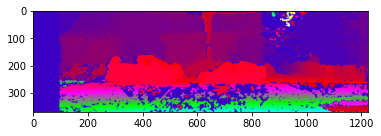

In [2]:
import cv2 as cv

NUM_DISP = 80
WINDOW_SIZE = 7

# use OpenCV's StereoSGBM method to compute disparity estimation dispI_est
# between the left image and the right image
# do not forget to divide the result by 16
leftI_gray = cv2.cvtColor(leftI, cv2.COLOR_BGR2GRAY)
rightI_gray = cv2.cvtColor(rightI, cv2.COLOR_BGR2GRAY)

stereo = cv.StereoSGBM_create(
    numDisparities=NUM_DISP,
    P1=8*3*WINDOW_SIZE**2,
    P2=32*3*WINDOW_SIZE**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    blockSize=WINDOW_SIZE,
    minDisparity=16
)
dispI_est = stereo.compute(leftI_gray, rightI_gray) / 16
max_disp = np.max(dispI_est)

# for debug ==
plt.imshow(rightI_gray, 'gray')
plt.show()
plt.imshow(dispI_est,'gray')
plt.show()
# ===

plt.imshow(disp_to_color(dispI_est, max_disp))

In [3]:
### KITTI parameters ###
f = 718.86 # focal 
cx = 607.19 # cx offset
cy = 185.22 # cy offset
B = 0.537 # baseline

# triangulate 3D Points
all_colors = cv2.cvtColor(leftI, cv2.COLOR_BGR2RGB)
height, width = leftI.shape[:2]

def triangulate(dispI, fn):
    points = []
    colors = []
    max_disp = np.max(dispI)
    # compute the 3D points for the given disparity image and their corresponding colors
    # by implementing triangulation (back-projection)
    for y in range(height):
        cur_points = []
        cur_colors = []
        for x in range(width):
            cur_depth = f * (B / (dispI[y, x]+ 1e-9)) # back projection formula (depth = f * (baseline/disparity))
            # make sure depth does not explode to inf due to division by small dispI values
            if cur_depth > max_disp:
                cur_depth = max_disp
            # undo the effect of cx and cy on the coordinates of the image plane
            cur_x = x - cx
            cur_y = y - cy
            # Backprojection of x and y coordinates given the cur_depth
            # Note that formula is x_c = x_s * z_c(i.edetpth) /f and y_c = y_s * z_c /f
            x_real = (cur_x * cur_depth) / f
            y_real = (cur_y * cur_depth) / f
            cur_points.append((x_real, y_real, cur_depth))
            
            cur_color = all_colors[y, x, :]
            cur_colors.append(cur_color)
        points.append(cur_points)
        colors.append(cur_colors) 


    points = np.array(points)
    colors = np.array(colors)
    write2ply(points, colors, fn)
    
triangulate(dispI_gt, 'out/pts_gt.ply')
triangulate(dispI_est, 'out/pts_est.ply')

print('done!')

done!


Visualize the 3D point clouds using MeshLab or Open3D. Note that you might have to rotate the point cloud a little bit until you can make sense of it, especially with the estimated disparity map where there are outliers.

**Bonus**: Implement the outlier ratio metric of the KITTI to evaluate the estimation quantitatively.

### Visualize the generated .ply files 

In [4]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("./out/pts_est.ply")
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
